In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as po
import plotly.graph_objs as go
from plotly import tools
import load
import descriptions
import gensim
import random
from keras.models import Model
from keras.models import load_model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Input
import keras
import time
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from platform import python_version
po.init_notebook_mode(connected=True)
pd.options.mode.chained_assignment = None

Using TensorFlow backend.


In [2]:
keras.__version__

'2.2.4'

In [3]:

print(python_version())

3.7.2


## Patient pathway

In [4]:
#this was made from the cancerdata_EDA.ipynb
full_patient_pathways = pd.read_pickle('full_patient_pathways.pkl')

print("shape of patient_pathways ",full_patient_pathways.shape)
display(full_patient_pathways.head())

shape of patient_pathways  (777581, 111)


TUMOURID  PATIENTID DIAGNOSISDATEBEST SITE_ICD10_O2 SITE_ICD10_O2_3CHAR  \
15  10001198   10001198        2015-01-16          C443                 C44   
18  10335837   10001198        2015-01-16          C444                 D46   
16  10001198   10001198        2015-01-16          C443                 C44   
17  10001198   10001198        2015-01-16          C443                 C44   
19  10335837   10001198        2015-01-16          C444                 D46   

   MORPH_ICD10_O2 BEHAVIOUR_ICD10_O2 T_BEST N_BEST M_BEST  ...  \
15           8090                  3    NaN    NaN    NaN  ...   
18           8090                  1    NaN    NaN    NaN  ...   
16           8090                  3    NaN    NaN    NaN  ...   
17           8090                  3    NaN    NaN    NaN  ...   
19           8090                  1    NaN    NaN    NaN  ...   

   ORG_CODE_OF_DRUG_PROVIDER ACTUAL_DOSE_PER_ADMINISTRATION  \
15                       EOI                           55.0   
18                       EOI                           55.0   
16                       EGT                          600.0   
17                       EQM                           70.0   
19                       EGT                          600.0   

   OPCS_DELIVERY_CODE  ADMINISTRATION_ROUTE ADMINISTRATION_DATE    DRUG_GROUP  \
15                721                     1          2015-09-02       STEROID   
18                721                     1          2015-09-02       STEROID   
16                NaN                     1          2015-09-03  BENDAMUSTINE   
17                NaN                     1          2015-09-03     CISPLATIN   
19                NaN                     1          2015-09-03  BENDAMUSTINE   

    MERGED_PATIENT_ID MERGED_TUMOUR_ID_y MERGED_REGIMEN_ID_y  \
15           10001198           10002225            10003952   
18           10001198           10002225            10003952   
16           10001198           10002225            10003952   
17           10001198           10002225            10003952   
19           10001198           10002225            10003952   

   DRUG_GROUP_CORRECT  
15            STEROID  
18            STEROID  
16       BENDAMUSTINE  
17          CISPLATIN  
19       BENDAMUSTINE  

[5 rows x 111 columns]

# Assigning events

In [5]:
#only use 3 character icd10 codes for simplicity
full_patient_pathways['PRIMARY_DIAGNOSIS'] = full_patient_pathways['PRIMARY_DIAGNOSIS'].apply(lambda x: x[0:3])

The following cell treats a diagnosis,regimen taken and drug taken as an individual event. These can be obtained from full_patient_pathways by getting each column of those events and a column that has the dates of those events. We can stack all events which will get a sequence of events(as rows) per patient.

In [6]:
event_types = ['PRIMARY_DIAGNOSIS',
               'BENCHMARK_GROUP',
               'DRUG_GROUP_CORRECT',
              'REGIMEN_MOD_DOSE_REDUCTION',
               'REGIMEN_MOD_TIME_DELAY',
               'REGIMEN_MOD_STOPPED_EARLY',
               'REGIMEN_OUTCOME_SUMMARY']
dates = ['DIAGNOSISDATEBEST',
         'START_DATE_OF_REGIMEN',
         'ADMINISTRATION_DATE',
        'DATE_OF_FINAL_TREATMENT',
         'DATE_OF_FINAL_TREATMENT',
         'DATE_OF_FINAL_TREATMENT',
         'DATE_OF_FINAL_TREATMENT']
sequences_df = pd.DataFrame()

for date, event_type in zip(dates,event_types):
    
    #get the events and event dates,
    #we must drop duplicates as some are replicated due to the merging
    #in cancerdata_EDA
    df = full_patient_pathways[['PATIENTID', date, event_type]].drop_duplicates()
    df = df.rename(index=str, columns={date:'date', event_type:'event'})
    
    #any event with 'N either means 
    #NO(nothing happend) or not known(for outcome summary)'
    df = df[df['event'] != 'N']
    
    df['event_type'] = event_type
    
    #get rid of NaN events
    df = df[df['event'].notnull()]
    
    #some drug group values are the same as there regimen values
    df['event'] = df['event_type'] + " " + df['event'].astype(str)
    
    
    #stack the events and event dates
    sequences_df = pd.concat([sequences_df,df])
    
sequences_df = sequences_df.sort_values(by = ['PATIENTID','date'])
    
sequences_df.head(10)

PATIENTID                 date                                    event  \
15   10001198  2015-01-16 00:00:00                    PRIMARY_DIAGNOSIS C44   
15   10001198           2015-02-27             BENCHMARK_GROUP FLUOROURACIL   
15   10001198  2015-09-02 00:00:00               DRUG_GROUP_CORRECT STEROID   
16   10001198  2015-09-03 00:00:00          DRUG_GROUP_CORRECT BENDAMUSTINE   
17   10001198  2015-09-03 00:00:00             DRUG_GROUP_CORRECT CISPLATIN   
21   10001976  2014-02-25 00:00:00                    PRIMARY_DIAGNOSIS C44   
24   10001976  2014-10-17 00:00:00                    PRIMARY_DIAGNOSIS C44   
21   10001976           2014-11-16  BENCHMARK_GROUP CISPLATIN + GEMCITABINE   
21   10001976  2015-01-18 00:00:00                 DRUG_GROUP_CORRECT TRIAL   
22   10001976  2015-01-18 00:00:00               DRUG_GROUP_CORRECT STEROID   

            event_type  
15   PRIMARY_DIAGNOSIS  
15     BENCHMARK_GROUP  
15  DRUG_GROUP_CORRECT  
16  DRUG_GROUP_CORRECT  
17  DRUG_GROUP_CORRECT  
21   PRIMARY_DIAGNOSIS  
24   PRIMARY_DIAGNOSIS  
21     BENCHMARK_GROUP  
21  DRUG_GROUP_CORRECT  
22  DRUG_GROUP_CORRECT

Convert dates to number of days passed since first event. 

The Simulacrum imitates data in 2013-2017 : https://simulacrum.healthdatainsight.org.uk/available-data/
so we should remove dates below these

In [7]:
#remove years below 2013
correct_years = pd.to_datetime(sequences_df['date']).apply(lambda date: date.year)>2012
sequences_df = sequences_df[correct_years]

#make a column 'days' which has the number of days
#since the first event of a given patient
df_dates = sequences_df[['PATIENTID','date']]
df_dates['date'] = pd.to_datetime(df_dates['date'])

#dates of the first event of a patient
df_start_dates = df_dates.groupby('PATIENTID').first().reset_index().rename(columns={'date':'start date'})

#days from the first event of a patient
df_dates = pd.merge(df_dates,df_start_dates,how='left')
df_dates['days'] = df_dates['date']-df_dates['start date']
sequences_df['days'] = [d.days for d in df_dates['days']]

#remove nans
sequences_df = sequences_df[sequences_df['days'].notnull()]

sequences_df.head(10)

PATIENTID                 date                                    event  \
15   10001198  2015-01-16 00:00:00                    PRIMARY_DIAGNOSIS C44   
15   10001198           2015-02-27             BENCHMARK_GROUP FLUOROURACIL   
15   10001198  2015-09-02 00:00:00               DRUG_GROUP_CORRECT STEROID   
16   10001198  2015-09-03 00:00:00          DRUG_GROUP_CORRECT BENDAMUSTINE   
17   10001198  2015-09-03 00:00:00             DRUG_GROUP_CORRECT CISPLATIN   
21   10001976  2014-02-25 00:00:00                    PRIMARY_DIAGNOSIS C44   
24   10001976  2014-10-17 00:00:00                    PRIMARY_DIAGNOSIS C44   
21   10001976           2014-11-16  BENCHMARK_GROUP CISPLATIN + GEMCITABINE   
21   10001976  2015-01-18 00:00:00                 DRUG_GROUP_CORRECT TRIAL   
22   10001976  2015-01-18 00:00:00               DRUG_GROUP_CORRECT STEROID   

            event_type  days  
15   PRIMARY_DIAGNOSIS     0  
15     BENCHMARK_GROUP    42  
15  DRUG_GROUP_CORRECT   229  
16  DRUG_GROUP_CORRECT   230  
17  DRUG_GROUP_CORRECT   230  
21   PRIMARY_DIAGNOSIS     0  
24   PRIMARY_DIAGNOSIS   234  
21     BENCHMARK_GROUP   264  
21  DRUG_GROUP_CORRECT   327  
22  DRUG_GROUP_CORRECT   327

In [8]:
#add diagnosis of patient as a column
cancers_df = full_patient_pathways[['PATIENTID','PRIMARY_DIAGNOSIS']].drop_duplicates()
sequences_df = pd.merge(sequences_df,cancers_df,how='left',on='PATIENTID')

Assign each unique event a label

In [9]:
unique_events_df = sequences_df[['event']].drop_duplicates().reset_index(drop=True)
unique_events_df['event_label'] = unique_events_df.index.astype(str)
unique_events_df.head()

event event_label
0            PRIMARY_DIAGNOSIS C44           0
1     BENCHMARK_GROUP FLUOROURACIL           1
2       DRUG_GROUP_CORRECT STEROID           2
3  DRUG_GROUP_CORRECT BENDAMUSTINE           3
4     DRUG_GROUP_CORRECT CISPLATIN           4

Add the event_label into the sequences_df

In [10]:
sequences_df = pd.merge(sequences_df, unique_events_df, how='left',on='event')
sequences_df.head(10)

PATIENTID                 date                                    event  \
0   10001198  2015-01-16 00:00:00                    PRIMARY_DIAGNOSIS C44   
1   10001198           2015-02-27             BENCHMARK_GROUP FLUOROURACIL   
2   10001198  2015-09-02 00:00:00               DRUG_GROUP_CORRECT STEROID   
3   10001198  2015-09-03 00:00:00          DRUG_GROUP_CORRECT BENDAMUSTINE   
4   10001198  2015-09-03 00:00:00             DRUG_GROUP_CORRECT CISPLATIN   
5   10001976  2014-02-25 00:00:00                    PRIMARY_DIAGNOSIS C44   
6   10001976  2014-10-17 00:00:00                    PRIMARY_DIAGNOSIS C44   
7   10001976           2014-11-16  BENCHMARK_GROUP CISPLATIN + GEMCITABINE   
8   10001976  2015-01-18 00:00:00                 DRUG_GROUP_CORRECT TRIAL   
9   10001976  2015-01-18 00:00:00               DRUG_GROUP_CORRECT STEROID   

           event_type  days PRIMARY_DIAGNOSIS event_label  
0   PRIMARY_DIAGNOSIS     0               C44           0  
1     BENCHMARK_GROUP    42               C44           1  
2  DRUG_GROUP_CORRECT   229               C44           2  
3  DRUG_GROUP_CORRECT   230               C44           3  
4  DRUG_GROUP_CORRECT   230               C44           4  
5   PRIMARY_DIAGNOSIS     0               C44           0  
6   PRIMARY_DIAGNOSIS   234               C44           0  
7     BENCHMARK_GROUP   264               C44           5  
8  DRUG_GROUP_CORRECT   327               C44           6  
9  DRUG_GROUP_CORRECT   327               C44           2

In [11]:
unique_events_df.shape, sequences_df.shape

((910, 2), (820065, 7))

There are 915 unique events and 820065 events in total

## word2vec

Convert each unique event into a vector of features.

These features are learned with a neural net using gensim, but we must give as input sequences of events to find out the features of these events.

In [12]:
#Create a series which has the sequence of events for a given patient
sequences = sequences_df.groupby(['PATIENTID'])['event_label'].agg(lambda x: list(x))
sequences.shape

(68687,)

In [13]:
#examples of sequences of events
print(list(sequences)[9])
print(list(sequences)[3])

['35', '5', '10', '7', '3', '10', '36', '25', '37', '10', '10', '38', '39', '40', '2', '41', '42']
['0', '11', '3', '10', '12', '10', '12']


In [14]:
#converts all events to vectors
model = gensim.models.Word2Vec(sentences = list(sequences),
                               size=100, 
                               window=120, 
                               workers =4, 
                               min_count=1,
                               iter = 10)

In [15]:
model['21'] #the vector for event 21

/Users/jeremyocampo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



array([-3.89515847e-01, -1.46470293e-01, -6.85732603e-01, -1.23848057e+00,
       -6.93019569e-01,  1.56566903e-01, -4.00440902e-01,  7.24121511e-01,
       -7.12167084e-01,  1.96986035e-01, -6.79879844e-01, -1.48580492e-01,
        6.02020144e-01,  1.68264598e-01, -1.57115650e+00, -2.79982805e-01,
       -5.47951818e-01,  8.28144252e-01,  2.95446575e-01, -3.02101940e-01,
        8.40327919e-01,  1.30512881e+00, -8.30872297e-01,  3.35374802e-01,
        6.79960847e-02,  2.89083123e-01, -4.75287557e-01, -1.08844066e+00,
       -2.34816119e-01,  1.49853718e+00, -2.64473587e-01,  6.29523620e-02,
        1.57323170e+00,  5.52778721e-01,  1.17610538e+00, -2.73811370e-01,
       -1.94745541e+00, -6.31037951e-01, -2.00191903e+00,  1.22784448e+00,
       -3.34079057e-04,  2.09432647e-01, -6.21219754e-01,  8.82155538e-01,
        2.93324292e-02,  1.36103296e+00, -6.06382847e-01,  1.78300679e-01,
        3.30662131e-02, -2.92428732e-01,  7.05999076e-01, -1.59767315e-01,
        4.36276585e-01,  

In [16]:
len(model.wv.vocab)

910

## Dimension reduction

Use PCA to reduce the size of the vectors and project onto an optimal 3D dimension where clusters of individual events may be identified

In [17]:
X = model[model.wv.vocab]
#pca = PCA(n_components=2)
#tsne = TSNE(n_components=2)
um = umap.UMAP(n_components=2)
result = um.fit_transform(X)

/Users/jeremyocampo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



* PCA finds the best projection of the data into a 2D plane such that the points are maximally separated.
* TSNE tries to preserve the same proportions of distances between points, in the 100D spae and the 3D space.
* not sure about umap


Get 2D co-ordinates of each event:

In [18]:
event_vector_df = pd.DataFrame({'event_label':list(model.wv.vocab.keys()),
                                'x':result[:,0],
                                'y':result[:,1]})
label_type_df = sequences_df[['event_type','event_label']].drop_duplicates()
event_vector_df = pd.merge(event_vector_df,label_type_df,on='event_label', how='left')

print(event_vector_df.shape)
event_vector_df.head()

(910, 4)


event_label         x         y          event_type
0           0  4.323184  1.084251   PRIMARY_DIAGNOSIS
1           1 -3.768540  3.198508     BENCHMARK_GROUP
2           2  0.867266  1.127976  DRUG_GROUP_CORRECT
3           3  5.968677  0.588969  DRUG_GROUP_CORRECT
4           4 -1.826478  1.238739  DRUG_GROUP_CORRECT

In [19]:
#plot the events, colour coded by event_type

data=[]
color = np.random.seed(seed=20)
#desc = [d for d in descriptions.get_descriptions(uniqcancer, 'icd')]
for event_type in event_types:
    color=np.random.randint(255, size=(1, 3))[0]
    x = event_vector_df[event_vector_df['event_type']==event_type]['x']
    y = event_vector_df[event_vector_df['event_type']==event_type]['y']
    
    trace = go.Scatter( x = x,
                        y = y,
                        mode = 'markers',
                        name = event_type,
                        marker = dict(size = 3,
                                      color = 'rgb({}, {}, {})'.format(*color)) )
    data.append(trace)

layout = dict(title = 'Visualisation of events',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )

fig = dict(data=data, layout=layout)
po.iplot(fig)

### patient pathway visualization

This section adds up all the word2vec vectors for a given individual patient, this is one way to visualize a pathway and to see if there are (di)similar pathways

In [20]:
#get the list of days corresponding to each event in a sequence of events
sequence_days = sequences_df.groupby(['PATIENTID'])['days'].agg(lambda x: list(x))
sequence_cancer_df = pd.DataFrame({'sequence':sequences,'sequence_days':sequence_days})

#get cancer diagnosis of each patient for colour coding
cancers_df = full_patient_pathways[['PATIENTID','PRIMARY_DIAGNOSIS']].drop_duplicates()
sequence_cancer_df = pd.merge(sequence_cancer_df,cancers_df,how='left',on='PATIENTID')

sequence_cancer_df['sequence_length'] = sequence_cancer_df['sequence'].apply(len)

sequence_cancer_df.head()

PATIENTID                                          sequence  \
0   10001198                                   [0, 1, 2, 3, 4]   
1   10001976                             [0, 0, 5, 6, 2, 7, 8]   
2   10002361                                     [0, 1, 9, 10]   
3   10002568                        [0, 11, 3, 10, 12, 10, 12]   
4   10002929  [13, 10, 14, 0, 15, 4, 16, 2, 17, 18, 0, 19, 10]   

                                       sequence_days PRIMARY_DIAGNOSIS  \
0                             [0, 42, 229, 230, 230]               C44   
1                  [0, 234, 264, 327, 327, 327, 434]               C44   
2                                 [0, 427, 427, 427]               C44   
3                  [0, 934, 962, 962, 963, 963, 990]               C44   
4  [0, 0, 7, 155, 184, 184, 184, 184, 184, 213, 2...               C44   

   sequence_length  
0                5  
1                7  
2                4  
3                7  
4               13

In [21]:
#create a map that gets you from the event to its 2D PCA vector
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(X)
map2D = {k:vector for k,vector in zip(model.wv.vocab.keys(),pca_vectors)}

Now add up the vectors of events in a sequence to get the pathway and plot it

In [22]:
data=[]

#color code by cancer type

top5cancers = sequence_cancer_df['PRIMARY_DIAGNOSIS'].value_counts().keys()[:5]

np.random.seed(seed=20)
for c in top5cancers:

    color = np.random.randint(255, size=(1, 3))[0]
    
    c_sequences = sequence_cancer_df[sequence_cancer_df['PRIMARY_DIAGNOSIS'] == c]
    c_sequences100 = random.choices(list(c_sequences['sequence']),k=100)
    
    legend = True
    for s in c_sequences100:
        event_vectors = np.array([list(map2D[e]) for e in s])
        pathway_coordinates = np.cumsum(event_vectors, axis=0)

    
        trace = go.Scatter( x = pathway_coordinates[:,0],
                            y = pathway_coordinates[:,1],
                            mode = 'lines',
                            name = c,
                            legendgroup = c,
                            line=dict(width=1,
                                      color='rgb({}, {}, {})'.format(*color)), 
                            showlegend = legend)
        legend = False
        data.append(trace)

layout = dict(title = 'Visualisation of pathways',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )

fig = dict(data=data, layout=layout)
po.iplot(fig)

The pathways look like they've clustered well according to the type of cancer, meaning similar cancers have similar drugs/regimens, this isn't really usefull information, so it's better to try and use a clustering algorithm on a specific cancer

what the ICD10 codes mean:

In [23]:
desc5 = descriptions.get_descriptions(top5cancers, 'icd')
for c,d in zip(top5cancers,desc5):
    print(c,d)

C50 MALIGNANT NEOPLASM OF BREAST
C34 MALIGNANT NEOPLASM OF LUNG
C18 MALIGNANT NEOPLASM OF COLON
C61 MALIGNANT NEOPLASM OF PROSTATE
C83 NON-HODGKIN"S LYMPHOMA


### Clustering of single cancer pathways with TFIDF

Start of by looking at c50 (breast)

In [24]:
single_cancer = 'C50' #3char
single_cancer_df = sequence_cancer_df[sequence_cancer_df['PRIMARY_DIAGNOSIS'] == single_cancer]
single_cancer_sequences = single_cancer_df['sequence']
single_cancer_df.head()

PATIENTID                                           sequence  \
41   10073021         [83, 84, 22, 85, 22, 8, 2, 47, 86, 10, 29]   
59   10120084                                    [62, 9, 10, 83]   
64   10137351                                [83, 21, 10, 2, 10]   
75   10153352                   [83, 124, 9, 10, 10, 47, 10, 30]   
77   10163033  [83, 120, 7, 124, 7, 10, 63, 17, 25, 2, 40, 12...   

                                        sequence_days PRIMARY_DIAGNOSIS  \
41  [0, 97, 97, 156, 156, 156, 163, 163, 414, 414,...               C50   
59                                     [0, 0, 0, 574]               C50   
64                            [0, 559, 559, 566, 566]               C50   
75             [0, 660, 681, 681, 702, 716, 716, 723]               C50   
77  [0, 415, 415, 417, 417, 438, 439, 439, 459, 54...               C50   

    sequence_length  
41               11  
59                4  
64                5  
75                8  
77               17

[TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) converts a collection of raw documents to a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features.

In the patient pathway case, given a sequence, the TF-IDF of an event in that sequence would be a number between 0 to 1.
This number will:
* increase if that event is frequent in that sequence
* decrease if that event is frequent in all sequences

Each sequence will have a vector where the elements are the TF-IDF values of the events in that sequence. We would like to cluster these vectors to represent the clustering of the pathways.

The downside to using this is that this vector does not have information on the order of events.

In [25]:
print("len(single_cancer_sequences):", len(single_cancer_sequences))
documents = [' '.join(s) for s in single_cancer_sequences]

#Make the sequences into vectors
vectorizer = TfidfVectorizer(max_df=1000000)
X = vectorizer.fit_transform(documents)
print("X.shape: ",X.shape)

#cluster these vectors
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=100, n_init=1).fit(X=X)
lab = kmeans.labels_
print("lab.shape: ",lab.shape)

len(single_cancer_sequences): 18661
X.shape:  (18661, 305)
lab.shape:  (18661,)


Add cluster labels

In [26]:
single_cancer_df['cluster'] = lab
single_cancer_df.head()

PATIENTID                                           sequence  \
41   10073021         [83, 84, 22, 85, 22, 8, 2, 47, 86, 10, 29]   
59   10120084                                    [62, 9, 10, 83]   
64   10137351                                [83, 21, 10, 2, 10]   
75   10153352                   [83, 124, 9, 10, 10, 47, 10, 30]   
77   10163033  [83, 120, 7, 124, 7, 10, 63, 17, 25, 2, 40, 12...   

                                        sequence_days PRIMARY_DIAGNOSIS  \
41  [0, 97, 97, 156, 156, 156, 163, 163, 414, 414,...               C50   
59                                     [0, 0, 0, 574]               C50   
64                            [0, 559, 559, 566, 566]               C50   
75             [0, 660, 681, 681, 702, 716, 716, 723]               C50   
77  [0, 415, 415, 417, 417, 438, 439, 439, 459, 54...               C50   

    sequence_length  cluster  
41               11        1  
59                4        1  
64                5        1  
75                8        1  
77               17        1

In [27]:
#use psa on the TFIDF vectors 'X' to visualize the sequences and how they've clustered
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(X.toarray())

single_cancer_df['x'] = pca_vectors[:,0]
single_cancer_df['y'] = pca_vectors[:,1]
single_cancer_df.head()

PATIENTID                                           sequence  \
41   10073021         [83, 84, 22, 85, 22, 8, 2, 47, 86, 10, 29]   
59   10120084                                    [62, 9, 10, 83]   
64   10137351                                [83, 21, 10, 2, 10]   
75   10153352                   [83, 124, 9, 10, 10, 47, 10, 30]   
77   10163033  [83, 120, 7, 124, 7, 10, 63, 17, 25, 2, 40, 12...   

                                        sequence_days PRIMARY_DIAGNOSIS  \
41  [0, 97, 97, 156, 156, 156, 163, 163, 414, 414,...               C50   
59                                     [0, 0, 0, 574]               C50   
64                            [0, 559, 559, 566, 566]               C50   
75             [0, 660, 681, 681, 702, 716, 716, 723]               C50   
77  [0, 415, 415, 417, 417, 438, 439, 439, 459, 54...               C50   

    sequence_length  cluster         x         y  
41               11        1  0.069390  0.019828  
59                4        1  0.060652  0.010328  
64                5        1 -0.068759 -0.022527  
75                8        1  0.020774 -0.007963  
77               17        1  0.050960  0.005686

In [28]:
#plot the TFIDF representation of a sequence

data=[]
color = np.random.seed(seed=21)

clusters = single_cancer_df['cluster'].unique()
for c in sorted(clusters):
    color=np.random.randint(255, size=(1, 3))[0]
    x = single_cancer_df[single_cancer_df['cluster']==c]['x']
    y = single_cancer_df[single_cancer_df['cluster']==c]['y']
    
    trace = go.Scattergl( x = x,
                        y = y,
                        mode = 'markers',
                        name = str(c),
                        legendgroup = str(c),
                        marker = dict(size = 4,
                                      color = 'rgb({}, {}, {})'.format(*color)) )
    data.append(trace)

layout = dict(title = 'Each point here represents a sequence in the TFIDF features space',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )

fig = dict(data=data, layout=layout)
po.iplot(fig)

An individual point on this plot represents the pathway of an individual patient. They are colour coded by the cluster they belong to.

The clustering doesn't seem to have done very well here

histogram of clusters:

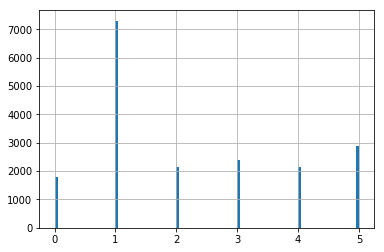

In [29]:
pd.Series(lab).hist(bins = 100)

The top 5 regimens and drugs in each cluster:

Given a cluster, what are the top drugs/regimens/outcome in that cluster, and how many days did it take until that event happened?

In [30]:
def clusterinfo(single_cancer_df,cluster=1,top=5):
    """display the top information of a cluster"""
    
    #get sequences_df of the single cancer
    df_single_cancer_seq = sequences_df[sequences_df['PRIMARY_DIAGNOSIS']==single_cancer]

    #add the cluster labels into the df_single_cancer_seq
    df_single_cancer_seq = pd.merge(df_single_cancer_seq,single_cancer_df[['PATIENTID','cluster']], how = 'left')

    #remove the event type in the 'event' column
    df_single_cancer_seq['event'] = [e[len(et)+1:] for e,et in
                                    zip(df_single_cancer_seq['event'],df_single_cancer_seq['event_type'])]
    
    print("Cluster",cluster,"\n")
    print("mean number of events: ",
          "%.2f" % single_cancer_df.groupby('cluster')['sequence_length'].mean()[cluster],
         "\n")
    
    print("top",top,"drugs, regimens and outcome, showing how many days from the first event that they were administered:")
    for event_type in ['DRUG_GROUP_CORRECT','BENCHMARK_GROUP','REGIMEN_OUTCOME_SUMMARY']:

        df_cluster_i = df_single_cancer_seq.loc[(df_single_cancer_seq['cluster'] == cluster)
                                      & (df_single_cancer_seq['event_type'] == event_type)]
        top5 = df_cluster_i['event'].value_counts()[:top]
        df_top5 = df_cluster_i[df_cluster_i['event'].isin(top5.keys())]
        mean_days = df_top5.groupby('event')['days'].mean()
        df_freq = pd.DataFrame(top5).reset_index().rename(columns={'index':event_type,'event':"frequency"})
        df_days = pd.DataFrame(mean_days).reset_index().rename(columns={'event':event_type,'days':'mean days'})
        df_freq_days = pd.merge(df_freq,df_days)

        display(df_freq_days)
    
        
clusterinfo(single_cancer_df)

Cluster 1 

mean number of events:  14.90 

top 5 drugs, regimens and outcome, showing how many days from the first event that they were administered:


DRUG_GROUP_CORRECT  frequency   mean days
0          NOT CHEMO      13912  331.824612
1   CYCLOPHOSPHAMIDE      11438  325.869208
2         EPIRUBICIN      10529  320.609175
3        TRASTUZUMAB       7963  287.584830
4       FLUOROURACIL       7681  325.421690

BENCHMARK_GROUP  frequency   mean days
0                            EC       2064  244.633721
1                    PACLITAXEL       1605  284.984424
2                     NOT CHEMO        913  246.893757
3  CYCLOPHOSPHAMIDE + DOCETAXEL        833  229.795918
4                     DENOSUMAB        601  349.301165

REGIMEN_OUTCOME_SUMMARY  frequency   mean days
0                       0        798  327.122807
1                       3        135  291.644444
2                       2         95  433.200000
3                       5         33  366.666667
4                       1         24  382.000000

### Using LSTM as an autoencoder for clustering

The LSTM sequence model used is shown in the diagram below. Using this we can extract the encoding(a vector of length 100 say) of any sequence. These encodings will have information on the order of the sequence and it's contents(events).

The LSTM autoencoder is trained to output the same sequence that it was input. This is so that given the information from the encoding, it should be able to reconstruct the same sequence from that encoding.

<img src="docs/LSTM.png" alt="LSTM" width="800"/>

For the inputs we will use the word2vec representation of events to improve computation speed:

In [31]:
model50D = gensim.models.Word2Vec(sentences = list(single_cancer_df['sequence']), 
                                  size=50, 
                                  window=120, 
                                  workers =4, 
                                  min_count=1,
                                  iter = 5)

sequence_vectors = single_cancer_sequences.apply(lambda x: np.array([list(model50D[event]) for event in x]))

sequence_vectors = list(sequence_vectors)

#in the word2vec representation of an event
#attach the number of days on the the end of that vector

#rescale days to have roughly the same magnitude as
#the elements in word2vec vectors
sequence_days = [np.array(days) for days in single_cancer_df['sequence_days']]
max_days = np.hstack(sequence_days).max()
max_vector_value = np.hstack([np.hstack(s_v) for s_v in sequence_vectors]).max()
sequence_days = [days*(max_vector_value/max_days) for days in sequence_days]

sequence_vectors = [np.concatenate((vectors,days.reshape(days.shape[0],-1)),axis=1) 
                    for vectors,days in zip(sequence_vectors,sequence_days)]

sequence_vectors[0]

/Users/jeremyocampo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



array([[-1.24067259e+00, -5.11830986e-01,  1.11944906e-01,
        -8.41284320e-02,  6.22065783e-01,  3.58891189e-02,
         3.27638924e-01,  1.79244623e-01, -4.68732178e-01,
        -2.98857212e-01, -1.21409900e-01,  3.31016332e-01,
         1.46415215e-02, -2.13619128e-01, -5.36124408e-01,
        -5.87338090e-01, -2.33150870e-01,  1.41708359e-01,
        -4.33021747e-02, -3.00247163e-01, -7.80052304e-01,
        -1.39048174e-01,  7.29504347e-01, -4.09324430e-02,
        -1.96129858e-01,  2.00324357e-01, -1.65309519e-01,
        -6.07949793e-01, -6.63930655e-01,  4.12678182e-01,
         3.77691925e-01, -2.99471557e-01,  3.21515530e-01,
        -5.46936870e-01,  7.49970198e-01,  5.06633136e-04,
         6.71876311e-01,  2.79410966e-02,  1.26747847e-01,
        -1.32681072e-01, -5.10697782e-01, -5.63653819e-02,
        -3.73017788e-01,  3.97741765e-01, -9.12322551e-02,
         5.98667143e-03, -2.65252650e-01,  4.25442159e-01,
        -7.16791272e-01,  3.77535880e-01,  0.00000000e+0

`sequence_vectors` contain the inputs into the LSTM model, and we are training the model to output the same input

The below cell contains:
* `train_generator()`: used to yield sequences which are then used to train the model
* LSTM model: the construction of the LSTM model structure
* `autoencoder`: The LSTM model is assigned to this variable. This is then compiled/trained

In [32]:
#this cell takes around 2 minutes to run

samples = 18661
batch_size = 500

sequence_vectors = sequence_vectors[:samples]
nsequences = len(sequence_vectors)

#this is needed in order for the model to
#work with sequences of differing lengths
def train_generator():
    """generates sequences from
    sequence_vectors at random"""
    while True:
        s = sequence_vectors[random.randrange(nsequences)]
        s = s.reshape((1, s.shape[0], s.shape[1]))
        yield s,s
        
train_gen = train_generator()
            
input_dim = 51
encoding_dim = 100

######### LSTM model
inputs = Input(shape=(None, input_dim))

middle_outputs, encoding, cell_state = LSTM(encoding_dim, return_sequences=True, return_state=True)(inputs)

outputs = LSTM(input_dim, return_sequences=True)(middle_outputs)
######### 

a = time.time()

autoencoder = Model(inputs=inputs, outputs=outputs)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit_generator(train_gen, 
                          steps_per_epoch=round(samples/batch_size), 
                          epochs=40,
                          verbose=1)

autoencoder.save('patient_pathway_autoencoder1.h5')

print("fit time (s): ", time.time() - a)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
37/37 [==============================] - 2s 68ms/step - loss: 0.1337
Epoch 2/40
37/37 [==============================] - 1s 30ms/step - loss: 0.1034
Epoch 3/40
37/37 [==============================] - 1s 30ms/step - loss: 0.0931
Epoch 4/40
37/37 [==============================] - 1s 31ms/step - loss: 0.0695
Epoch 5/40
37/37 [==============================] - 1s 34ms/step - loss: 0.0562
Epoch 6/40
37/37 [==============================] - 1s 29ms/step - loss: 0.0486
Epoch 7/40
37/37 [==============================] - 1s 35ms/step - loss: 0.0339
Epoch 8/40
37/37 [==============================] - 1s 31ms/step - loss: 0.0321
Epoch 9/40
37/37 [==============================] - 1s 29ms/step - loss: 0.0310
Epoch 10/40
37/37 [==============================] - 1s 28ms/step - loss: 0.0251
Epoch 11/40
37/37 [==============================] - 1s 34ms/step - loss: 0.027

In [33]:
autoencoder = load_model('patient_pathway_autoencoder1.h5')

#make a model with the output as the encoding
encoder_model = Model(inputs = autoencoder.inputs, outputs = autoencoder.layers[1].output)

Get the encodings of each sequence:

In [34]:
%%time
#reshape into correct input shape
input_sequences = [np.expand_dims(s, axis=0) for s in list(sequence_vectors)]

sequence_features = np.zeros((18661,100))
for i,s in enumerate(input_sequences):
    
    #get the encoding(hidden layer)
    sequence_features[i,:] = encoder_model.predict(s)[1]

CPU times: user 3min 46s, sys: 27.6 s, total: 4min 14s
Wall time: 57.4 s


Cluster the encodings

In [35]:
#clustering the encodings of all sequences
#30 clusters chosen as they are a lot more distinct,see plot below

kmeans = KMeans(n_clusters=20, init='k-means++', max_iter=100, n_init=1).fit(X=sequence_features)
lab = kmeans.labels_
print("lab.shape: ",lab.shape)

single_cancer_df['cluster'] = lab
single_cancer_df.to_pickle("patiend_id_cluster.pkl")

lab.shape:  (18661,)


In [36]:
#map the encodings into 2D space
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(sequence_features)

single_cancer_df['x'] = pca_vectors[:,0]
single_cancer_df['y'] = pca_vectors[:,1]
single_cancer_df.head()

PATIENTID                                           sequence  \
41   10073021         [83, 84, 22, 85, 22, 8, 2, 47, 86, 10, 29]   
59   10120084                                    [62, 9, 10, 83]   
64   10137351                                [83, 21, 10, 2, 10]   
75   10153352                   [83, 124, 9, 10, 10, 47, 10, 30]   
77   10163033  [83, 120, 7, 124, 7, 10, 63, 17, 25, 2, 40, 12...   

                                        sequence_days PRIMARY_DIAGNOSIS  \
41  [0, 97, 97, 156, 156, 156, 163, 163, 414, 414,...               C50   
59                                     [0, 0, 0, 574]               C50   
64                            [0, 559, 559, 566, 566]               C50   
75             [0, 660, 681, 681, 702, 716, 716, 723]               C50   
77  [0, 415, 415, 417, 417, 438, 439, 439, 459, 54...               C50   

    sequence_length  cluster         x         y  
41               11       16 -1.416273  0.087966  
59                4        9 -1.299736 -0.579092  
64                5       13 -0.418714  0.931878  
75                8       18  2.137361 -0.490221  
77               17       16 -1.568587 -0.004901

In [37]:
#plot the encodings

data=[]
color = np.random.seed(seed=21)

clusters = single_cancer_df['cluster'].unique()
for c in sorted(clusters):
    color=np.random.randint(255, size=(1, 3))[0]
    x = single_cancer_df[single_cancer_df['cluster']==c]['x']
    y = single_cancer_df[single_cancer_df['cluster']==c]['y']
    
    trace = go.Scattergl( x = x,
                        y = y,
                        mode = 'markers',
                        name = str(c),
                        legendgroup = str(c),
                        marker = dict(size = 4,
                                      color = 'rgb({}, {}, {})'.format(*color)) )
    data.append(trace)

layout = dict(title = 'Each point here represents a sequence in the LSTM embedding space',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )

fig = dict(data=data, layout=layout)
po.iplot(fig)

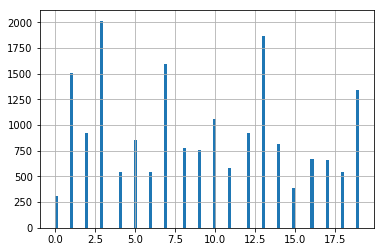

In [38]:
#histogram of clusters
pd.Series(lab).hist(bins = 100)

In [39]:
clusterinfo(single_cancer_df,cluster=7)

Cluster 7 

mean number of events:  9.61 

top 5 drugs, regimens and outcome, showing how many days from the first event that they were administered:


DRUG_GROUP_CORRECT  frequency   mean days
0   CYCLOPHOSPHAMIDE       2136  179.397472
1          NOT CHEMO       1677  172.323196
2         EPIRUBICIN       1483  167.795684
3            STEROID       1481  191.790007
4       FLUOROURACIL       1222  164.864975

BENCHMARK_GROUP  frequency   mean days
0      TRASTUZUMAB        397  193.740554
1              FEC        334  106.820359
2        DOCETAXEL        304  147.990132
3         HORMONES        279  108.982079
4  FEC + DOCETAXEL        203  112.054187

REGIMEN_OUTCOME_SUMMARY  frequency   mean days
0                       0         71  161.169014
1                       3         11  148.727273
2                       2          4  241.500000
3                       5          1  429.000000

In [40]:
single_cancer_df.to_pickle("patiend_id_cluster.pkl")